In [43]:
from labellines import *
from plot_disk import grcor
import matplotlib.pyplot as plt
import astropy.constants as c
import astropy.units as u
import numpy as np

def r_grav(m):
    grav_radius = ((c.G * m) / (c.c**2))
    return grav_radius.to(u.cm)

def get_r_isco(a, M):
    z1 = 1 + np.cbrt(1 - a**2) * (np.cbrt(1 + a) + np.cbrt(1 - a))
    z2 = np.sqrt(3*a**2 + z1**2)
    r_isco = (c.G * M / c.c.cgs**2 * (3 + z2 - np.sqrt((3-z1) * (3 + z1 + 2*z2)))).to(u.cm)
    return r_isco

def f_function(a, r, M):
    qcor, tcor = grcor(a, r/r_grav(M))
    return tcor**4

def F_gr(a, r, M, Mdot):
    flux = 3. * c.G * M * Mdot / (8. * np.pi * r**3) * f_function(a, r, M)    # Calculate the flux
    flux[flux<0.] = 0.
    return flux.to(u.Unit("erg/(cm2 s)"))

def F_newt(a, r, M, Mdot):
    flux = 3. * c.G * M * Mdot / (8. * np.pi * r**3) * (1. - np.sqrt(get_r_isco(a, M) / r))    # Calculate the flux
    return flux.to(u.Unit("erg/(cm2 s)")) # Return the flux with the right units!

In [54]:
M = 6.62 * u.solMass
Mdot = 0.000025 * u.solMass/u.yr
#a_vals = [1e-8, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999999999]
a_vals = [1e-8, 0.2, 0.4, 0.6, 0.8, 0.999999999]

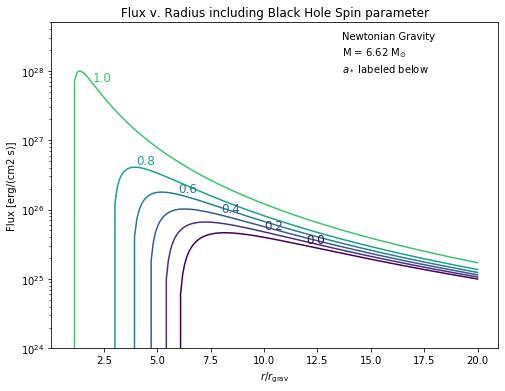

In [146]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.viridis(np.linspace(0, 0.7, len(a_vals)))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i, a in enumerate(a_vals):
    isco = get_r_isco(a, M).value
    r = np.linspace(isco, 20*r_grav(M).value, 150)*u.cm
    ax.plot(r/r_grav(M), F_newt(a, r, M, Mdot).value, c=colors[i], label='{:.1f}'.format(a))
plt.yscale('log')
plt.ylim(1e24, 5e28)
plt.title('Flux v. Radius including Black Hole Spin parameter')
plt.ylabel('Flux [erg/(cm2 s)]')
plt.xlabel(r'$r / r_{\rm grav}$')
plt.text(0.65, 0.95, "Newtonian Gravity", transform = ax.transAxes)
plt.text(0.65, 0.90, "M = 6.62 M$_{\odot}$", transform = ax.transAxes)
plt.text(0.65, 0.85, "$a_*$ labeled below", transform = ax.transAxes)


labelLines(ax.get_lines()[::-1], 
           align=False, 
           fontsize=12, 
           xvals=np.linspace(2, 12, len(a_vals)), 
           verticalalignment='bottom', 
           horizontalalignment='left')
plt.show()
    

## How do we intepret this plot?

There are a few interesting considerations to point out, even just in the Newtonian case.

 - The Innermost Stable Circular Orbit can clearly be seen at the inside edge of the disk.
     - We're using our `get_r_isco` function to calculate the ISCO, which should give us 6 gravitational radii for a non-spinning black hole. If you look at the line labeled 0.0, you'll see that it drops to zero right at r = 6 r_grav. That's perfect!
     - We also see that the line with a_* = 1.0 falls off at r = 1 r_grav. That also agrees with the theory value, so our equation is working correctly. **Faster-spinning black holes are smaller --- their event horizons are closer in to the singularity.**
 - The accretion disk is brightest close-in to the disk.
     - This makes sense because this is where the gravitational forces are strongest, meaning material is orbiting faster and experiences more friction against other gas. This makes it heat up and glow, which is what we're seeing.

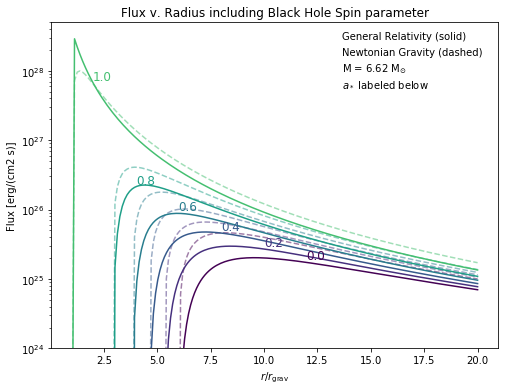

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i, a in enumerate(a_vals):
    isco = get_r_isco(a, M).value
    r = np.linspace(1.0000001*isco, 20*r_grav(M).value, 150)*u.cm
    ax.plot(r/r_grav(M), F_gr(a, r, M, Mdot).value, c=colors[i], label='{:.1f}'.format(a))
    ax.plot(r/r_grav(M), F_newt(a, r, M, Mdot).value, ls='--', c=colors[i], alpha=0.5)

plt.yscale('log')
plt.ylim(1e24, 5e28)
plt.title('Flux v. Radius including Black Hole Spin parameter')
plt.ylabel('Flux [erg/(cm2 s)]')
plt.xlabel(r'$r / r_{\rm grav}$')
plt.text(0.65, 0.95, "General Relativity (solid)", transform = ax.transAxes)
plt.text(0.65, 0.90, "Newtonian Gravity (dashed)", transform = ax.transAxes)
plt.text(0.65, 0.85, "M = 6.62 M$_{\odot}$", transform = ax.transAxes)
plt.text(0.65, 0.80, "$a_*$ labeled below", transform = ax.transAxes)


labelLines(ax.get_lines()[::-1], 
           align=False, 
           fontsize=12, 
           xvals=np.linspace(2, 12, len(a_vals)), 
           verticalalignment='bottom', 
           horizontalalignment='left')
plt.show()

## What are the important differences?

 - The General Relativistic calculations seem to reduce the flux across the radial profile, with the biggest difference occuring near the inner edge of the accretion disk.
 - The main differences can be attributed to the `f_function`, which contains all the physics that is different from Newtonian gravity. This can be seen in the figure below:

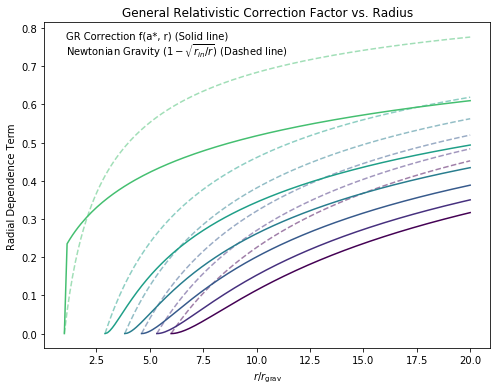

In [165]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
#r = np.linspace(6*r_grav(M).value, 20*r_grav(M).value, 150)*u.cm
for i, a in enumerate(a_vals):
    isco = get_r_isco(a, M).value
    r = np.linspace(1.0000001*isco, 20*r_grav(M).value, 150)*u.cm
    ax.plot(r/r_grav(M), f_function(a, r, M), c=colors[i], label="{:.1f}".format(a))
    ax.plot(r/r_grav(M), (1 - np.sqrt(isco*u.cm/r)), c=colors[i], ls='--', alpha=0.5)
plt.text(0.05, 0.95, "GR Correction f(a*, r) (Solid line)", transform = ax.transAxes)
plt.text(0.05, 0.90, r"Newtonian Gravity $(1 - \sqrt{r_{in}/r})$ (Dashed line)", transform = ax.transAxes)
plt.title("General Relativistic Correction Factor vs. Radius")
plt.xlabel(r"$r/r_{\rm grav}$")
plt.ylabel("Radial Dependence Term")
plt.show()